In [11]:
import os
import quantumpropagator as qp
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.linalg import toeplitz
from quantumpropagator import fromLabelsToFloats, labTranformA
np.set_printoptions(linewidth=250, edgeitems=5)

%matplotlib inline
#matplotlib notebook

In [12]:
fol = 'C:\\Users\\utente\\Desktop\\DATA\\'
#fn1 = os.path.join(fol,'datanewoneWithNACnow.npy')
fn2 = os.path.join(fol,'newExtrapolated_gammaExtrExag.pickle')
data = qp.pickleLoad(fn2)
print(data.keys())


pot = data['potCube']
phi_min, gam_min, the_min, state_min = np.unravel_index(pot.argmin(), pot.shape)

phi_slice_min = pot[:,gam_min, the_min, state_min]
gam_slice_min = pot[phi_min,:, the_min, state_min]
the_slice_min = pot[phi_min,gam_min, :, state_min]

qp.warning('Theta and Gamma have different values of K matrix along them')

phi_min, gam_min, the_min, state_min

dict_keys(['kinCube', 'smoCube', 'phis', 'geoCUBE', 'dipCUBE', 'gams', 'potCube', 'thes'])


******************************************************************
*                                                                *
*  Theta and Gamma have different values of K matrix along them  *
*                                                                *
******************************************************************





(29, 28, 55, 0)

In [13]:
phis_ext = labTranformA(data['phis'])
gams_ext = labTranformA(data['gams'])
thes_ext = labTranformA(data['thes'])

phiV_ext, gamV_ext, theV_ext = fromLabelsToFloats(data)

dphi = phiV_ext[0] - phiV_ext[1]
dgam = gamV_ext[0] - gamV_ext[1]
dthe = theV_ext[0] - theV_ext[1]

# take range
range_phi = phiV_ext[-1] - phiV_ext[0]
range_gam = gamV_ext[-1] - gamV_ext[0]
range_the = theV_ext[-1] - theV_ext[0]


header = '         Labels extr.        internal extr.     dq      range\n'
string = 'Phi -> {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}\nGam -> {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}\nThe -> {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'
out = (header + string).format(phiV_ext[-1],phiV_ext[0],phis_ext[-1],phis_ext[0],dphi,range_phi,
                               gamV_ext[-1],gamV_ext[0],gams_ext[-1],gams_ext[0],dgam,range_gam,
                               theV_ext[-1],theV_ext[0],thes_ext[-1],thes_ext[0],dthe,range_the)
print(out)

         Labels extr.        internal extr.     dq      range
Phi ->   0.1250  -0.1450  12.5000 -14.5000  -0.0050   0.2700
Gam ->   0.4294   0.1344  24.6050   7.7030  -0.0054   0.2950
The ->   0.5806   1.2008  66.5340 137.6000   0.0039  -0.6202


In [14]:
def forcehere(vec,ind,h=None):
    '''
    calculates the numerical force at point at index index
    vector :: np.array(double)
    index :: Int
    '''
    if h == None:
        warning('dimensionality is not clear')
        h = 1
    num = (-vec[ind-2]+16*vec[ind-1]-30*vec[ind]+16*vec[ind+1]-vec[ind+2])
    denom = 12 * h**2
    return(num/denom)


force_phi = forcehere(phi_slice_min, phi_min, h=dphi)
force_gam = forcehere(gam_slice_min, gam_min, h=dgam)
force_the = forcehere(the_slice_min, the_min, h=dthe)

coe_phi = data['kinCube'][phi_min, gam_min, the_min, 0, 2]
coe_gam = data['kinCube'][phi_min, gam_min, the_min, 4, 2]
coe_the = data['kinCube'][phi_min, gam_min, the_min, 8, 2]

G_phi = 1 / ( -2 * coe_phi )
G_gam = 1 / ( -2 * coe_gam )
G_the = 1 / ( -2 * coe_the )

Gw_phi = np.sqrt(force_phi*G_phi)
Gw_gam = np.sqrt(force_gam*G_gam)
Gw_the = np.sqrt(force_the*G_the)

Gw_phi = 2.553413e+04
Gw_gam = 5.722417e+03
Gw_the = 1.631186e+03

phi_0 = phiV_ext[phi_min]
gam_0 = gamV_ext[gam_min]
the_0 = theV_ext[the_min]

wf_phi = np.empty_like(phiV_ext)
for p, phi in enumerate(phiV_ext):
    wf_phi[p] = qp.gaussian2(phi, phi_0, Gw_phi, 0)
    
wf_gam = np.empty_like(gamV_ext)
for g, gam in enumerate(gamV_ext):
    wf_gam[g] = qp.gaussian2(gam, gam_0, Gw_gam, 0)
    
wf_the = np.empty_like(theV_ext)
for t, the in enumerate(theV_ext):
    wf_the[t] = qp.gaussian2(the, the_0, Gw_the, 0)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part


NameError: name 'maxx' is not defined

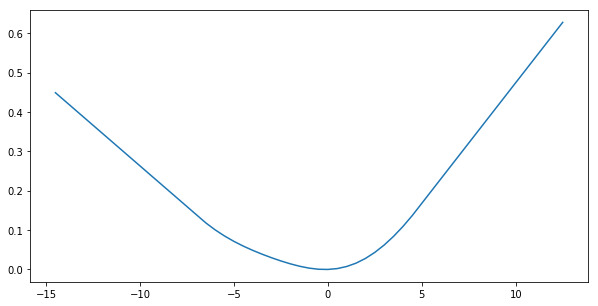

In [15]:
def troiaio(potential,MASS,num,ddim):
    
    p_matrix = toeplitz([-(5/2), (4/3), -(1/12), *np.zeros(potential.size-3)])

    matrix_divided = p_matrix/(ddim**2)

    new = matrix_divided * MASS
    linear_pot_diagonal = np.diag(potential)
    to_diagonalize = (linear_pot_diagonal + new)
    
    eigVal, eigVec = np.linalg.eigh(to_diagonalize)
    return(eigVec)    

        
num = 0
        
troi = troiaio(phi_slice_min, coe_phi, num, dphi)

ground_state = troi[:,0]

normalized = ground_state/(np.linalg.norm(ground_state))

wf_phi_n = wf_phi/(np.linalg.norm(wf_phi))

fig = plt.figure(figsize=(10,5))

plt.plot(phis_ext, phi_slice_min, label='Potential')
plt.plot(phis_ext, normalized, label='Eigenvector with "mass" {}'.format(maxx),lw='.5')
plt.plot(phis_ext, wf_phi_n, label='What we always got')

plt.legend()
plt.tight_layout();


In [16]:
def normalize_this_please(x):
    return(x/np.linalg.norm(x))



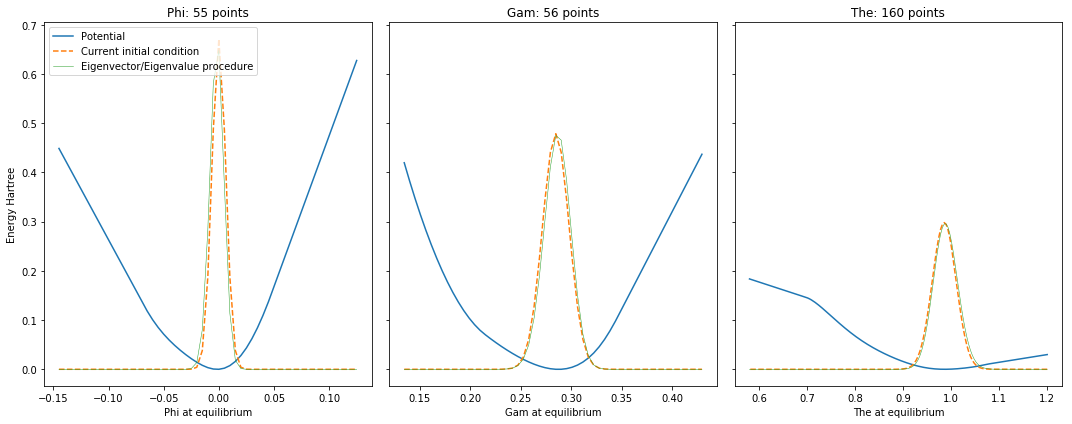

In [17]:
num = 0

# listz = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
        
list_in_phi = troiaio(phi_slice_min, coe_phi,num,dphi)
list_in_gam = troiaio(gam_slice_min, coe_gam,num,dgam)
list_in_the = troiaio(the_slice_min, coe_the,num,dthe)

fig, [ax0,ax1,ax2] = plt.subplots(1, 3, figsize=(15,6), sharey=True)

#norm = 5.145840
# norm = 1

ax0.plot(phiV_ext, phi_slice_min, label='Potential')
ax0.plot(phiV_ext, normalize_this_please(wf_phi), label='Current initial condition', ls='--')
ax0.plot(phiV_ext, abs(list_in_phi[:,0]), lw=0.5, label='Eigenvector/Eigenvalue procedure')
ax0.set_title('Phi: 55 points')
ax0.set_ylabel('Energy Hartree')
ax0.set_xlabel('Phi at equilibrium')
ax0.legend()

ax1.plot(gamV_ext, gam_slice_min)
ax1.plot(gamV_ext, normalize_this_please(wf_gam), ls='--')
ax1.plot(gamV_ext, abs(list_in_gam[:,0]), lw=0.5)
#ax1.axvline(x=gamV_ext[28])
ax1.set_title('Gam: 56 points')
ax1.set_xlabel('Gam at equilibrium')

ax2.plot(theV_ext, the_slice_min)
ax2.plot(theV_ext, normalize_this_please(wf_the), ls='--')
ax2.plot(theV_ext, abs(list_in_the[:,0]), lw=0.5)
ax2.set_title('The: 160 points')
ax2.set_xlabel('The at equilibrium')





fig.savefig('C:\\Users\\utente\\Desktop\\Dropbox\\u-3dPropagation_manuscript\\Report\\images\\initialskew.png')

fig.tight_layout()

In [28]:
def troiaio2(potential,MASS,num,ddim):
    
    p_matrix = toeplitz([-(5/2), (4/3), -(1/12), *np.zeros(potential.size-3)])

    matrix_divided = p_matrix/(ddim**2)

    new = matrix_divided * MASS
    linear_pot_diagonal = np.diag(potential)
    to_diagonalize = (linear_pot_diagonal + new)
    
    eigVal, eigVec = np.linalg.eigh(to_diagonalize)
    return(eigVal, eigVec)

eigVal_phi, eigVec_phi = troiaio2(phi_slice_min, coe_phi,num,dphi)
eigVal_gam, eigVec_gam  = troiaio2(gam_slice_min, coe_gam,num,dgam)
eigVal_the, eigVec_the  = troiaio2(the_slice_min, coe_the,num,dthe)

In [44]:
(eigVal_phi[0]-eigVal_phi[1])

-0.004045786306196331

In [27]:
(0.00195115- 0.00599694)*27.21

-0.11008594590000002

In [31]:
(eigVal_gam[0]-eigVal_gam[1])*27.21

-0.19555854718683915

In [32]:
(eigVal_the[0]-eigVal_the[1])*27.21

-0.05756865612923376

In [42]:
print(data['dipCUBE'].shape)
data['dipCUBE'][28,29,55,:,0,0],data['dipCUBE'][28,29,55,:,1,1]

(55, 56, 160, 3, 8, 8)


(array([2.99811259e-05, 5.51990712e-05, 2.11588560e-01]),
 array([-6.28606479e-04, -3.89539345e-04,  1.06922449e+00]))

In [43]:
data['dipCUBE'][20,29,55,:,0,0],data['dipCUBE'][20,29,55,:,1,1]

(array([ 0.00027804,  0.00105638, -0.19670413]),
 array([ 1.45309240e-04,  1.34356896e-04, -2.26745850e-01]))

In [ ]:
-11271.29027    -37.59698